# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 11002 / 11441 MB available


In [9]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i=blockIdx.x*blockDim.x+threadIdx.x;
    unsigned int j=blockIdx.y*blockDim.y+threadIdx.y;
    
    //Pseudocode
    //c[j][i]=a[j][a]+b[j][i]
    unsigned int k=j*cols+i;
    
    c[k]=a[k]+b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

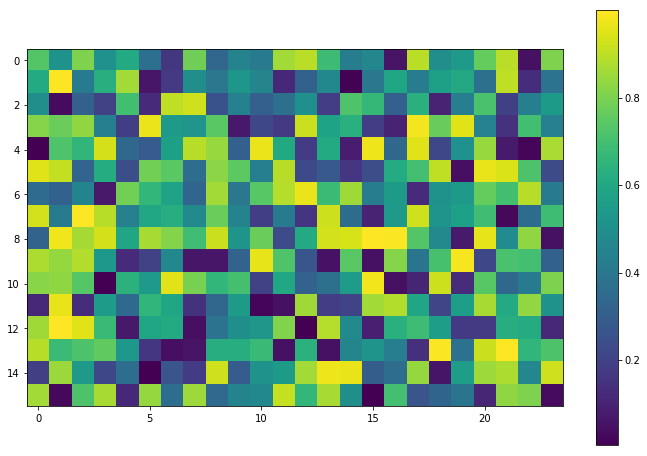

In [13]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig=plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()
               

In [14]:
print(a.shape)

(16, 24)


In [15]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [16]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [31]:
#a.shape=(row, cols)
domain_size=(a.shape[0], a.shape[1])
print(a.shape)
print(domain_size)
block_size=(8, 4, 1)
grid_size=(domain_size[0]//block_size[0], domain_size[1]//block_size[1], 1)

print("Domain size is" + str(domain_size))
print("Block size is" + str(block_size))
print("Grid size is" + str(grid_size))

(16, 24)
(24, 16)
Domain size is(24, 16)
Block size is(8, 4, 1)
Grid size is(3, 4, 1)


In [34]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[1]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.84603274, 1.0539024 , 0.9365161 , 0.6291928 , 1.1104126 ,
        0.52397305, 0.20699261, 1.1931462 , 0.54723006, 1.4329891 ,
        0.88215595, 1.5130227 , 1.5361316 , 1.5011942 , 1.2865348 ,
        0.90680075, 0.40705273, 1.4599257 , 0.9306183 , 1.0076197 ,
        0.82014996, 1.5069833 , 1.0449607 , 1.27523   ],
       [1.0185004 , 1.2940122 , 1.1965754 , 1.1009394 , 0.99369544,
        0.7203448 , 0.28731978, 0.7468431 , 0.91450584, 0.8789568 ,
        0.87932193, 0.8956412 , 1.1066272 , 0.79567564, 0.1721309 ,
        1.0891508 , 0.9600228 , 1.2431258 , 1.0959761 , 1.0874974 ,
        1.0113878 , 1.8739963 , 0.72278714, 1.1736696 ],
       [1.1027347 , 0.52299386, 1.0575439 , 0.60540354, 0.90471834,
        0.68210983, 1.5616913 , 0.9761215 , 0.81280833, 0.8316835 ,
        0.8947575 , 1.2412565 , 1.136451  , 1.1206322 , 1.1401925 ,
        0.7220592 , 0.53286654, 1.6088588 , 0.6944813 , 1.3032582 ,
        1.5402037 , 0.5168835 , 1.4199255 , 1.3113451 ],
       [1.487

In [35]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.84603274 1.0539024  0.9365161  0.6291928  1.1104126  0.52397305
  0.20699261 1.1931462  0.54723006 1.4329891  0.88215595 1.5130227
  1.5361316  1.5011942  1.2865348  0.90680075 0.40705273 1.4599257
  0.9306183  1.0076197  0.82014996 1.5069833  1.0449607  1.27523   ]
 [1.0185004  1.2940122  1.1965754  1.1009394  0.99369544 0.7203448
  0.28731978 0.7468431  0.91450584 0.8789568  0.87932193 0.8956412
  1.1066272  0.79567564 0.1721309  1.0891508  0.9600228  1.2431258
  1.0959761  1.0874974  1.0113878  1.8739963  0.72278714 1.1736696 ]
 [1.1027347  0.52299386 1.0575439  0.60540354 0.90471834 0.68210983
  1.5616913  0.9761215  0.81280833 0.8316835  0.8947575  1.2412565
  1.136451   1.1206322  1.1401925  0.7220592  0.53286654 1.6088588
  0.6944813  1.3032582  1.5402037  0.5168835  1.4199255  1.3113451 ]
 [1.4874907  1.2603726  0.8645607  1.1368803  1.0060992  1.4472818
  0.7175075  1.5175085  0.7659029  0.3272106  0.55595756 0.3753777
  1.7576652  1.1893299  0.7462085  1.0330787  1

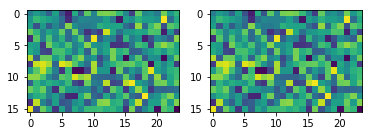

In [30]:
plt.figure()

plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)